In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
!pip install transformers
!pip install gensim
!pip install pymorphy2
!pip install catboost

В данном ноутбуке представлены три способа решения задачи классификации:
1. Простые алгоритмы машинного обучения, такие как логистическая регрессия, random forest, KNN и пр. с токенизацией слов с помощью tf-idf
2. Алгоритм KNN с Word2Vec
3. Модель rubert-tiny2

# Анализ датасета

In [4]:
df = pd.read_csv('/content/drive/My Drive/imsit/articles_lemmatized_no_SW.csv')
df.head()

,Unnamed: 0,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый накануне февраль возникать сложный вопр...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто


In [5]:
df.shape

(56500, 4)

In [6]:
mx_body_len = 0
mx_headline_len = 0
for i in range(len(df)):
  if type(df['body'][i]) != float:
    mx_body_len = max(len(df['body'][i]), mx_body_len)
  if type(df['headline'][i]) != float:
    mx_headline_len = max(len(df['headline'][i]), mx_headline_len)

In [7]:
print(mx_body_len, mx_headline_len)

48095 75


In [8]:
topics = list(set(df['topic']))

Присвоим каждой теме свой номер

In [9]:
df['modified_topic'] = [topics.index(cur_topic) for cur_topic in df['topic']]

In [10]:
to_drop = []
for i in df.index:
  if type(df['body'][i]) == float or type(df['topic'][i]) == float:
    to_drop.append(i)
df = df.drop(to_drop)
df.shape

(56499, 5)

In [11]:
df['body'] = [df['body'][i] + df['headline'][i] for i in df.index]

In [12]:
df.topic.value_counts()

Мир                                    15131
Общество                               12147
Политика                                7359
Страна                                  5280
Экономика                               5032
Спорт                                   4881
Культура                                2635
Армия                                   1295
Наука                                    824
Гаджеты & Телеком                        583
РИО-2016                                 449
Авто                                     130
Москва                                   118
День в истории                           108
Выборы в США                              96
Выборы-2016                               92
ПМЭФ                                      63
День Победы                               62
ЧЕ 2016                                   56
Известия: подробности                     38
Россия - регионы                          26
Новости компаний                          17
Финансы   

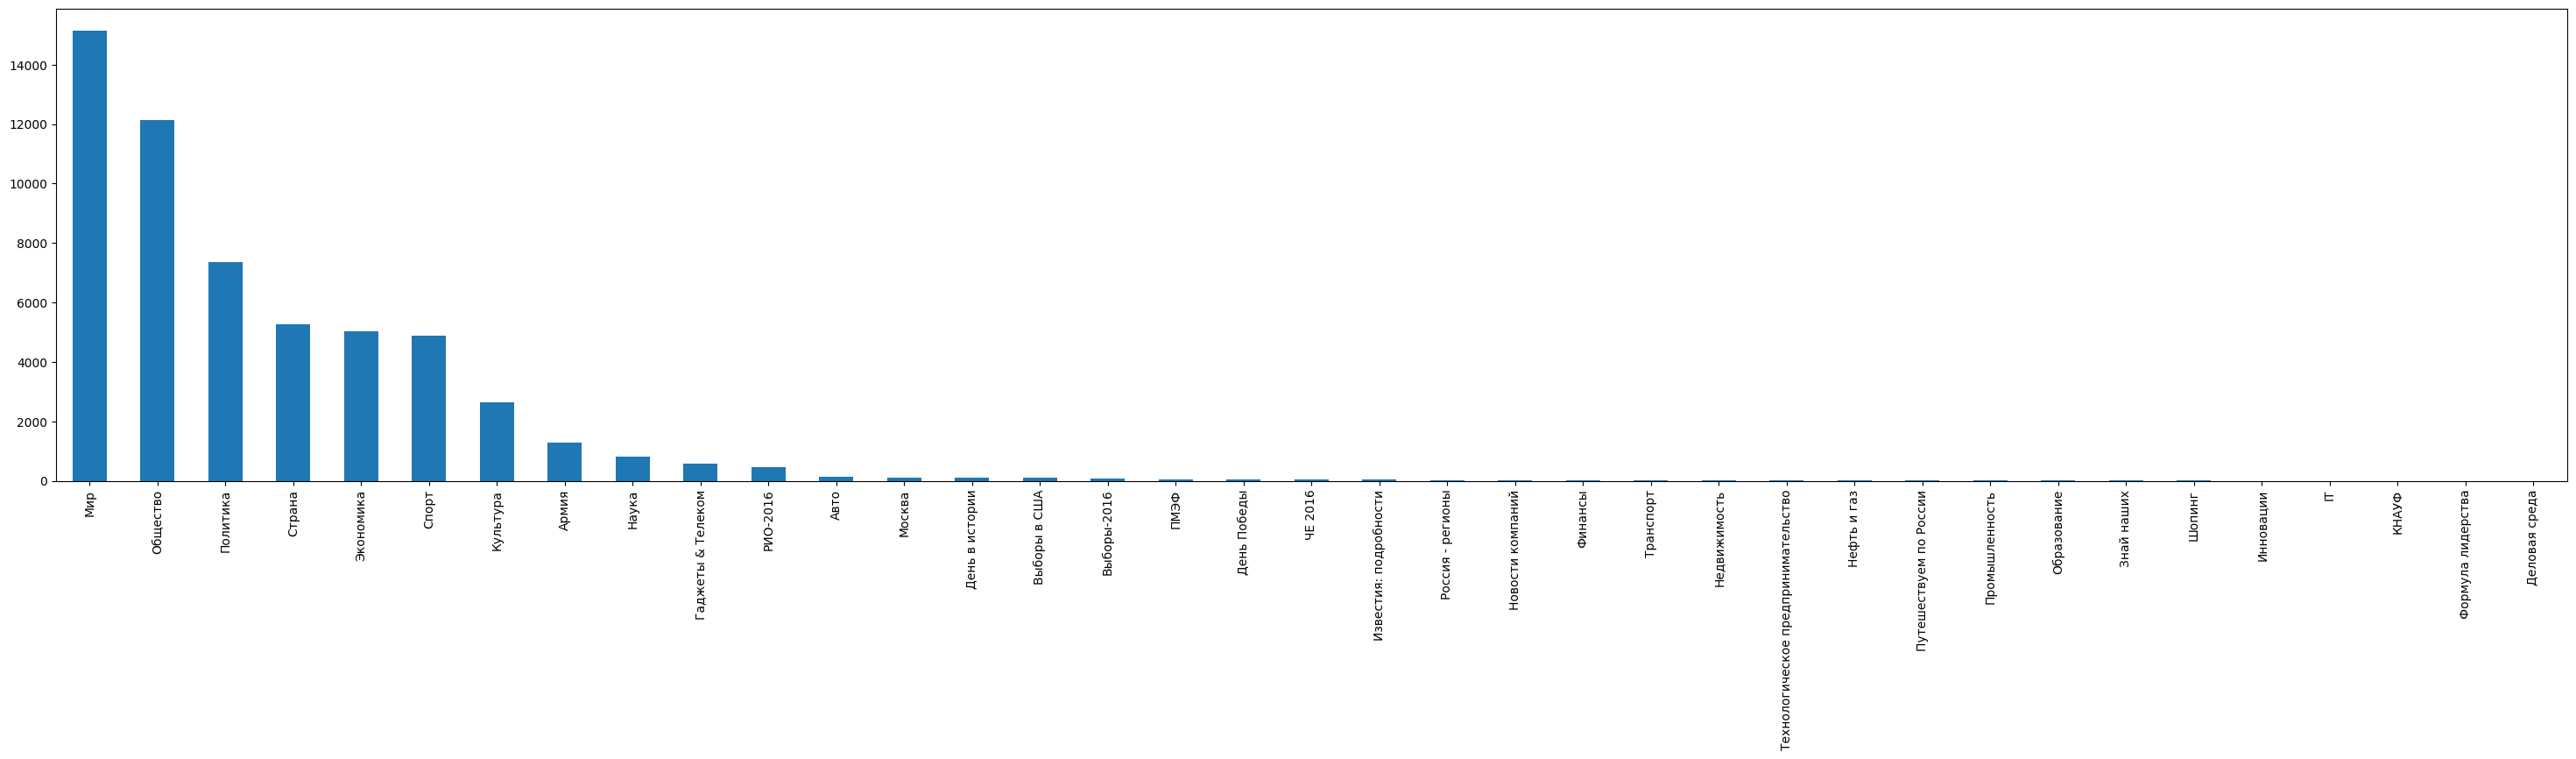

In [13]:
my_tags = topics
plt.figure(figsize=(len(topics),7))
df.topic.value_counts().plot(kind='bar');

Видим, что категории несбалансированы.

#Tf-idf

In [35]:
x = df.body
y = df.modified_topic

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state = 30)

In [37]:
print(len(x_train), len(x_test))

50849 5650


In [38]:
performance = []

In [39]:
def run_model(model_name):
    mdl = ""
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression(n_jobs=1, C=1e5)
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'SGD Classifier':
        mdl = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10, p = 4, metric='cosine')

    nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', mdl),
    ])
    nb.fit(x_train, y_train)

    # Performance metrics
    y_pred = nb.predict(x_test)
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1-score : {f1score}')

    # Add performance parameters to list
    performance.append(dict([('Model', model_name),('Test Accuracy', round(accuracy, 2)),('Precision', round(precision, 2)),('Recall', round(recall, 2)),('F1', round(f1score, 2))]))

In [40]:
run_model('Logistic Regression')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy Score of Basic Logistic Regression: % 77.77
Precision : 0.7776991150442478
Recall : 0.7776991150442478
F1-score : 0.7776991150442479


In [45]:
run_model('Random Forest')

Test Accuracy Score of Basic Random Forest: % 71.4
Precision : 0.7139823008849557
Recall : 0.7139823008849557
F1-score : 0.7139823008849557


In [41]:
run_model('Multinomial Naive Bayes')

Test Accuracy Score of Basic Multinomial Naive Bayes: % 61.15
Precision : 0.6115044247787611
Recall : 0.6115044247787611
F1-score : 0.6115044247787611


In [42]:
run_model('SGD Classifier')

Test Accuracy Score of Basic SGD Classifier: % 72.53
Precision : 0.7253097345132743
Recall : 0.7253097345132743
F1-score : 0.7253097345132743


In [44]:
run_model('Decision Tree Classifier')

Test Accuracy Score of Basic Decision Tree Classifier: % 60.32
Precision : 0.6031858407079645
Recall : 0.6031858407079645
F1-score : 0.6031858407079645


In [43]:
run_model('K Nearest Neighbour')

Test Accuracy Score of Basic K Nearest Neighbour: % 70.21
Precision : 0.7021238938053097
Recall : 0.7021238938053097
F1-score : 0.7021238938053097


In [46]:
model_performance = pd.DataFrame(data=performance)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,77.77,0.78,0.78,0.78
1,Multinomial Naive Bayes,61.15,0.61,0.61,0.61
2,SGD Classifier,72.53,0.73,0.73,0.73
3,K Nearest Neighbour,70.21,0.70,0.70,0.70
4,Decision Tree Classifier,60.32,0.60,0.60,0.60
5,Random Forest,71.40,0.71,0.71,0.71


In [47]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
print("The best accuracy is", max_value, "%")

The best accuracy is 77.77 %


# KNN & word2vec

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
wv = KeyedVectors.load_word2vec_format(datapath("/content/drive/My Drive/imsit/model.bin"), binary=True)

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
import logging
from tqdm import tqdm
def word_averaging(wv, words):
    all_words, mean = set(), []

    for word in words:
        parse_result = morph.parse(word)[0].tag.POS
        word_morph = word
        if parse_result != None:
            word_morph += ("_" + parse_result)
        if word_morph in wv.key_to_index:
            mean.append(wv.vectors[wv.key_to_index[word_morph]])
            all_words.add(wv.key_to_index[word_morph])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    word_av_list = []
    for post in tqdm(text_list):
        word_av_list.append(word_averaging(wv, post))
    return np.vstack(word_av_list)

In [ ]:
import nltk
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='russian'):
        for word in nltk.word_tokenize(sent, language='russian'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
train, test = train_test_split(df, test_size=0.10, random_state = 30)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['body']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['body']), axis=1).values

In [ ]:
x_train_word_average = word_averaging_list(wv,train_tokenized)
x_test_word_average = word_averaging_list(wv,test_tokenized);

100%|██████████| 5650/5650 [03:34<00:00, 26.40it/s]


In [ ]:
model = KNeighborsClassifier(n_neighbors=10, p = 4, metric='cosine')
model = model.fit(x_train_word_average, train['modified_topic'])
y_pred = model.predict(x_test_word_average)

In [ ]:
y_test = test['modified_topic']

In [ ]:
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='micro')
print(f'Test Accuracy Score of KNN: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1score}')

Test Accuracy Score of KNN: % 65.65
Precision : 0.6564601769911504
Recall : 0.6564601769911504
F1-score : 0.6564601769911504


# BERT

## Tokenizing & saving tokens

In [14]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2', do_lower_case=True)

Loading BERT tokenizer...


In [15]:
from tqdm import tqdm
import torch

input_ids = []
attention_masks = []

for sample in tqdm(df.to_numpy()):
    sequence = sample[2]

    encoded_dict = tokenizer.encode_plus(
                        sequence,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/56499 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 56499/56499 [08:26<00:00, 111.56it/s]


In [16]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [17]:
labels = torch.tensor(df.modified_topic.to_numpy())

In [18]:
input_ids.shape, attention_masks.shape, labels.shape

(torch.Size([56499, 512]), torch.Size([56499, 512]), torch.Size([56499]))

In [19]:
torch.save(input_ids, '/content/drive/My Drive/imsit/inputs.pt')
torch.save(attention_masks, '/content/drive/My Drive/imsit/attention_masks.pt')
torch.save(labels, '/content/drive/My Drive/imsit/labels.pt')

## Loading tokens

In [20]:
input_ids = torch.load('/content/drive/My Drive/imsit/inputs.pt')
attention_masks = torch.load('/content/drive/My Drive/imsit/attention_masks.pt')
labels = torch.load('/content/drive/My Drive/imsit/labels.pt')

In [21]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

50,849 training samples
5,650 validation samples


In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## Train

In [23]:
device = "cuda:0"
#device = "cpu"

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels = 37,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [25]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [27]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
torch.cuda.empty_cache()

In [33]:
import random
import matplotlib.pyplot as plt

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    preds_global = []
    labels_global = []
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        preds_global += list(np.argmax(logits, axis=1).flatten())
        labels_global += list(label_ids.flatten())


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,590.    Elapsed: 0:00:09.
  Batch    80  of  1,590.    Elapsed: 0:00:18.
  Batch   120  of  1,590.    Elapsed: 0:00:27.
  Batch   160  of  1,590.    Elapsed: 0:00:37.
  Batch   200  of  1,590.    Elapsed: 0:00:46.
  Batch   240  of  1,590.    Elapsed: 0:00:55.
  Batch   280  of  1,590.    Elapsed: 0:01:05.
  Batch   320  of  1,590.    Elapsed: 0:01:14.
  Batch   360  of  1,590.    Elapsed: 0:01:24.
  Batch   400  of  1,590.    Elapsed: 0:01:33.
  Batch   440  of  1,590.    Elapsed: 0:01:43.
  Batch   480  of  1,590.    Elapsed: 0:01:52.
  Batch   520  of  1,590.    Elapsed: 0:02:01.
  Batch   560  of  1,590.    Elapsed: 0:02:11.
  Batch   600  of  1,590.    Elapsed: 0:02:20.
  Batch   640  of  1,590.    Elapsed: 0:02:30.
  Batch   680  of  1,590.    Elapsed: 0:02:39.
  Batch   720  of  1,590.    Elapsed: 0:02:48.
  Batch   760  of  1,590.    Elapsed: 0:02:58.
  Batch   800  of  1,590.    Elapsed: 0:03:07.
  Batch   840  of

In [34]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.8074907415505476,
  'Valid. Loss': 0.7640493818595584,
  'Valid. Accur.': 0.7693228185812931,
  'Training Time': '0:06:13',
  'Validation Time': '0:00:15'},
 {'epoch': 2,
  'Training Loss': 0.7109734809225273,
  'Valid. Loss': 0.7166990506446967,
  'Valid. Accur.': 0.7829174513496547,
  'Training Time': '0:06:15',
  'Validation Time': '0:00:15'},
 {'epoch': 3,
  'Training Loss': 0.6667708584909919,
  'Valid. Loss': 0.7048071151399343,
  'Valid. Accur.': 0.7876844005021971,
  'Training Time': '0:06:14',
  'Validation Time': '0:00:15'},
 {'epoch': 4,
  'Training Loss': 0.6558400529173185,
  'Valid. Loss': 0.7048071151399343,
  'Valid. Accur.': 0.7876844005021971,
  'Training Time': '0:06:14',
  'Validation Time': '0:00:15'}]

# Итоги

В ходе экспериментов установили, что наилучший результат показывает rubert-tiny2. Я считаю ее наболее применимой для решения данной задачи.

Использование Word2Vec с KNN ухудшает результат, вероятно, из-за того, что русский словарь содержит мало слов или имеет недостаточно высокое качество. Однако его реализация занимает столько же времени, сколько обучение rubert-tiny2, поэтому данный алгоритм можно назвать неэффективным.

Простые алгоритмы вроде логистической регрессии также показывают довольно неплохие результаты и применимы для решения задачи.

Стоит заметить, что в датасете содержатся довольно длинные тексты, которые токенайзер rubert-tiny2 не может обработать полностью, т.к. максимальная длина sequence для него всего 512 токенов. Для улучшения результата можно использовать longformer и также заменить ruber-tiny2 на rubert-base при большем количестве вычислительных ресурсов.

